<a href="https://colab.research.google.com/github/avkornaev/Sleep_Stages/blob/main/SleepStages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install pytorch-lightning clearml

In [32]:
# ---------------------------
# 1. Imports & Environment Setup
# ---------------------------
import os
import shutil  # Add this line
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pytorch_lightning as pl
from typing import Optional, List, Dict, Tuple
from collections import defaultdict
from clearml import Task
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt  # Add this
import seaborn as sns            # Add this

In [33]:
# Set up reproducibility
SEED = 42
pl.seed_everything(SEED)
torch.set_float32_matmul_precision('high')

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [34]:
#Enter your code here to implement Step 2 of the logging instruction as it is shown below
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
%env CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
env: CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I


In [35]:
DATASET = 'Sleep_Stages' # dataset with the real-world noise
#Clone the GitHub repository
repo_url = "https://github.com/avkornaev/Sleep_Stages"  # Replace with your repo URL
!git clone {repo_url}

#Navigate to the data folder
repo_name = repo_url.split("/")[-1].replace(".git", "")  # Extract repo name
data_dir = os.path.join(repo_name, "data")  # Replace "data" with your folder name
# os.chdir(data_dir)  # Change working directory to the data folder

# Verify the data directory
if os.path.exists(data_dir):
    print(f"Data directory found: {data_dir}")
else:
    print(f"Data directory not found: {data_dir}")

fatal: destination path 'Sleep_Stages' already exists and is not an empty directory.
Data directory found: Sleep_Stages/data


In [36]:
# ---------------------------
# 2. Configuration Constants
# ---------------------------
CONFIG = {
    "data_dir": "Sleep_Stages/data",
    "checkpoint_path": "saved_models/",
    "batch_size": 128,
    "window_size": 600,
    "learning_rate": 1e-3,
    "max_epochs": 5,
    "num_workers": 2
}

Loading raw data...
Common labels: ['N2', 'R']


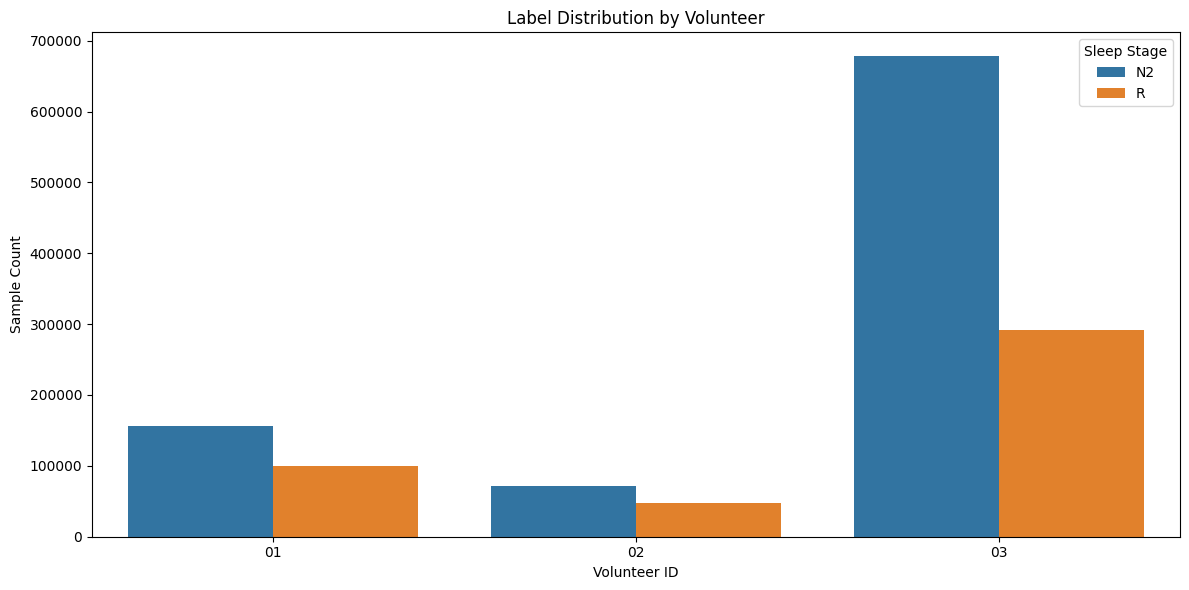

<ipython-input-37-e63fb63263ed>:111: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




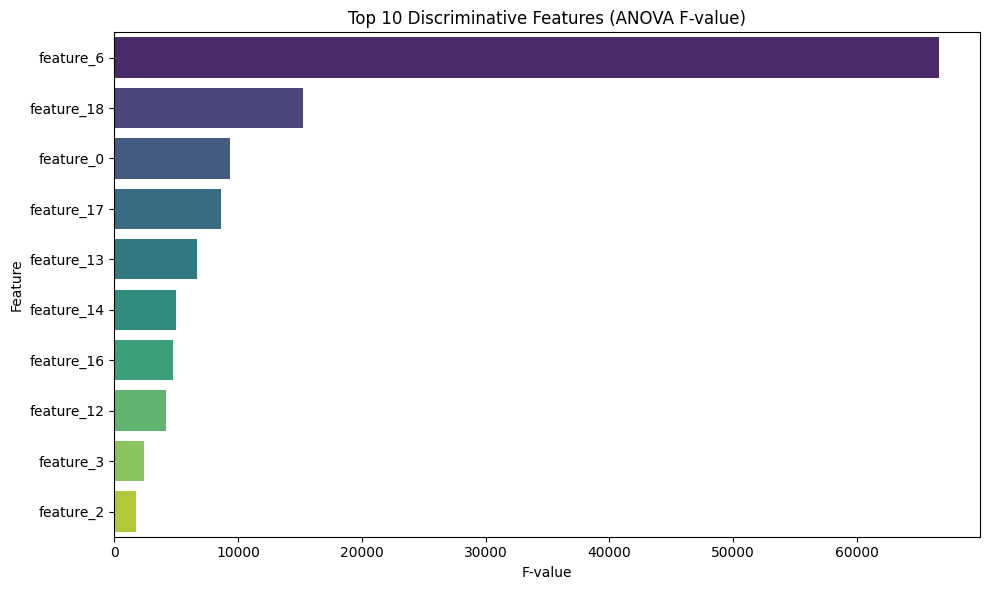

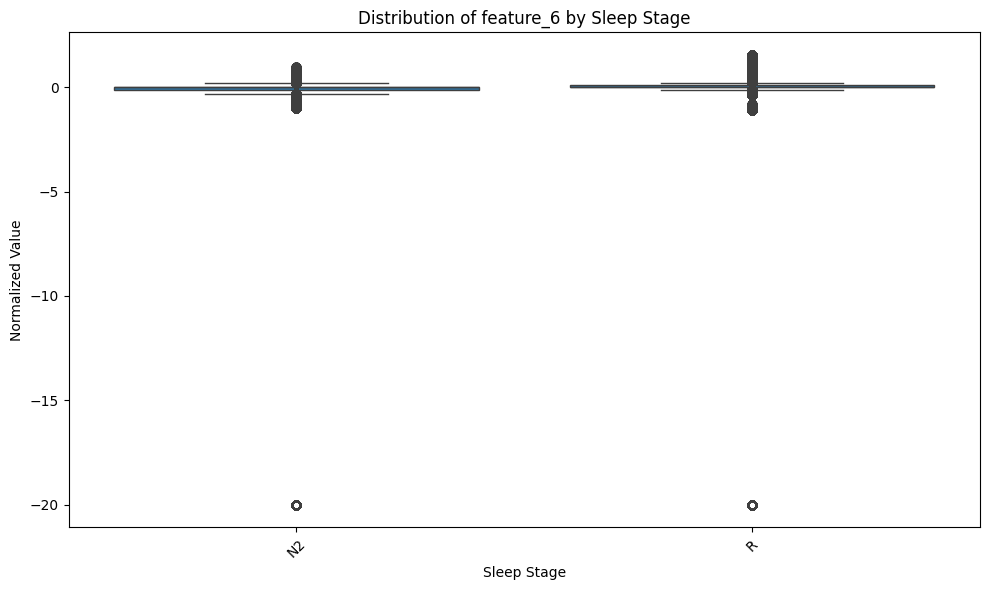

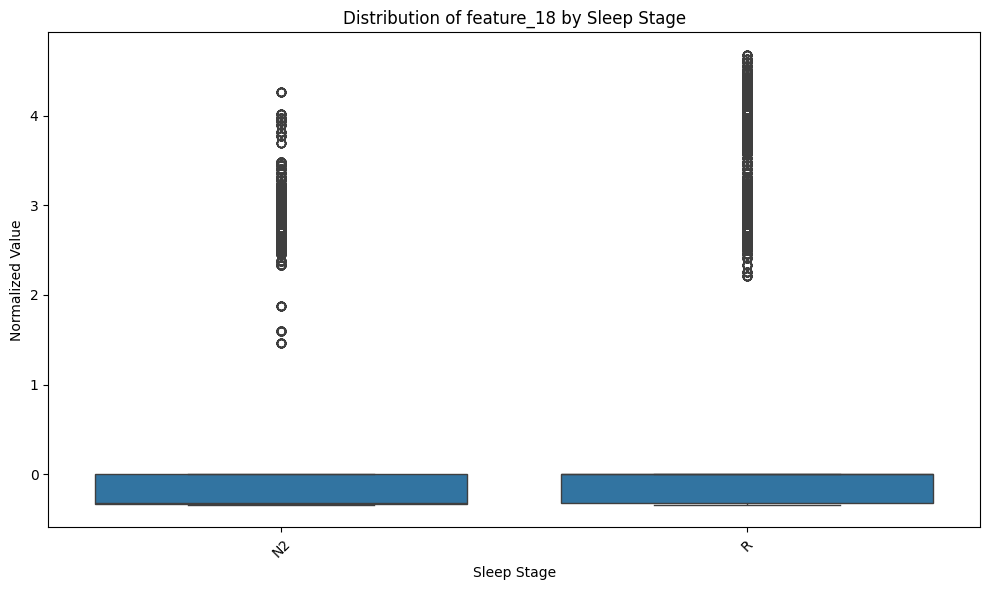

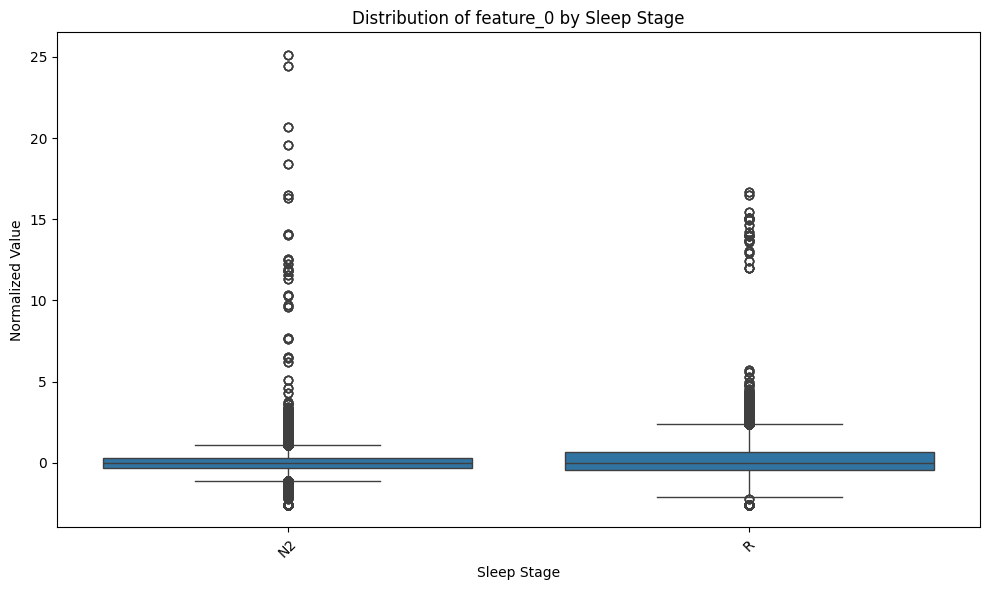


Preprocessed Data Sample:


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,volunteer,label
957285,-1.314944,0.285194,-0.029562,-0.171642,-0.175937,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,03,R
1255426,-0.551055,0.295141,0.210299,-0.713961,-0.971283,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.330143,-0.459262,-0.296217,0.000000,0.000000,0.000000,0.000000,0.000000,03,N2
602751,-0.508617,-0.053016,0.570090,0.448150,0.237088,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.340675,-0.459262,-0.296217,0.000000,0.000000,0.000000,0.000000,0.000000,03,N2
795243,0.000000,0.000000,0.000000,0.000000,0.000000,0.070484,0.710264,0.495309,0.438668,-0.429169,...,-0.341890,-0.459262,-0.296217,0.837596,0.739557,-0.297802,-0.613850,-0.325289,03,N2
160881,0.000000,0.000000,0.000000,0.000000,0.000000,-0.028129,-0.330616,-2.472536,-2.136814,2.336907,...,2.395941,1.012185,-0.272288,-1.027293,-0.767749,-0.054228,-0.311849,-0.321567,01,N2



LOSO Example: Training on 4084 samples, Validating on 398 samples


In [37]:
# ---------------------------
# 3. Data Preprocessing Block
# ---------------------------
def load_and_preprocess_data(directory: str) -> Tuple[pd.DataFrame, Dict[str, tuple], List[str]]:
    """Enhanced preprocessing with visualization and data validation"""
    # First pass: Load raw data and calculate global statistics
    raw_data = defaultdict(list)
    all_features = []
    label_sets = defaultdict(set)

    print("Loading raw data...")
    for filename in os.listdir(directory):
        if not filename.startswith("Vol_") or not filename.endswith(".csv.gz"):
            continue

        try:
            df = pd.read_csv(os.path.join(directory, filename),
                           compression='gzip', skiprows=1, header=None,
                           dtype={i: np.float32 for i in range(19)})
            df.columns = [f"feature_{i}" for i in range(19)] + ["label"]
            df['label'] = df['label'].str.strip().replace('', np.nan)
            df = df.dropna(subset=['label'])

            vol_id = filename.split("_")[1].split(".")[0]
            raw_data[vol_id].append(df)
            label_sets[vol_id].update(df['label'].unique())
            all_features.append(df.iloc[:, :-1].values)
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue

    # Calculate global imputation values
    global_mean = np.nanmean(np.concatenate(all_features), axis=0)
    global_std = np.nanstd(np.concatenate(all_features), axis=0)

    # Determine common labels across all volunteers
    common_labels = set(label_sets[next(iter(label_sets))])
    for labels in label_sets.values():
        common_labels.intersection_update(labels)
    common_labels = sorted(common_labels)
    if not common_labels:
        raise ValueError("No common labels found across all volunteers")
    print(f"Common labels: {common_labels}")

    # Second pass: Process each volunteer with validation
    processed_data = {}
    combined_dfs = []
    label_to_id = {lbl: idx for idx, lbl in enumerate(common_labels)}

    for vol_id, dfs in raw_data.items():
        full_df = pd.concat(dfs)

        # Data cleaning
        full_df = full_df[full_df['label'].isin(common_labels)]
        for i in range(19):
            full_df[f'feature_{i}'] = full_df[f'feature_{i}'].fillna(global_mean[i])

        # Validate label presence
        present_labels = full_df['label'].unique()
        if len(present_labels) != len(common_labels):
            print(f"Skipping {vol_id} - missing labels. Present: {present_labels}")
            continue

        # Normalization
        features = (full_df.iloc[:, :19].values - global_mean) / (global_std + 1e-8)
        labels = full_df['label'].map(label_to_id).values

        # Store processed data
        processed_data[f"Vol_{vol_id}"] = (features.astype(np.float32), labels.astype(np.long))

        # Create visualization dataframe
        vis_df = pd.DataFrame(features, columns=[f"feature_{i}" for i in range(19)])
        vis_df['volunteer'] = vol_id
        vis_df['label'] = full_df['label'].values
        combined_dfs.append(vis_df)

    if not processed_data:
        raise ValueError("No valid volunteers after preprocessing")

    combined_df = pd.concat(combined_dfs, ignore_index=True)
    return combined_df, processed_data, common_labels

# ---------------------------
# 4. Data Visualization
# ---------------------------
def visualize_data(combined_df: pd.DataFrame, common_labels: List[str]):
    """Generate comprehensive visualizations of the dataset"""
    plt.figure(figsize=(12, 6))
    sns.countplot(data=combined_df, x='volunteer', hue='label',
                order=sorted(combined_df['volunteer'].unique()),
                hue_order=common_labels)
    plt.title('Label Distribution by Volunteer')
    plt.xlabel('Volunteer ID')
    plt.ylabel('Sample Count')
    plt.legend(title='Sleep Stage')
    plt.tight_layout()
    plt.show()

    # Feature importance analysis
    from sklearn.feature_selection import f_classif
    X = combined_df[[c for c in combined_df.columns if c.startswith('feature_')]]
    y = combined_df['label'].factorize()[0]

    f_values, _ = f_classif(X, y)
    feat_importance = pd.DataFrame({
        'Feature': X.columns,
        'F-value': f_values
    }).sort_values('F-value', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='F-value', y='Feature', data=feat_importance, palette='viridis')
    plt.title('Top 10 Discriminative Features (ANOVA F-value)')
    plt.tight_layout()
    plt.show()

    # Box plots for top 3 features
    top_features = feat_importance.head(3)['Feature'].tolist()
    for feat in top_features:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='label', y=feat, data=combined_df,
                  order=common_labels)
        plt.title(f'Distribution of {feat} by Sleep Stage')
        plt.xlabel('Sleep Stage')
        plt.ylabel('Normalized Value')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Display sample data
    print("\nPreprocessed Data Sample:")
    display(combined_df.sample(5, random_state=SEED))

# ---------------------------
# 5. Dataset & DataLoaders
# ---------------------------
class SleepDataset(Dataset):
    def __init__(self, features: np.ndarray, labels: np.ndarray, window_size: int):
        self.windows, self.labels = self._create_windows(features, labels, window_size)

    def _create_windows(self, features, labels, window_size):
        windows = []
        window_labels = []
        for start in range(0, len(features) - window_size + 1, window_size//2):
            window = features[start:start+window_size].T  # (features, time)
            label = labels[start+window_size-1]
            windows.append(window)
            window_labels.append(label)
        return torch.FloatTensor(windows), torch.LongTensor(window_labels)

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        return self.windows[idx], self.labels[idx]

class SleepDataModule(pl.LightningDataModule):
    def __init__(self, processed_data: Dict[str, tuple], config: dict):
        super().__init__()
        self.data = processed_data
        self.config = config
        self.datasets = {}

    def setup(self, stage: Optional[str] = None):
        for vol_id, (feats, lbls) in self.data.items():
            self.datasets[vol_id] = SleepDataset(feats, lbls, self.config['window_size'])

    def get_loso_splits(self, test_vol: str):
        train_feats, train_lbls = [], []
        for vol_id, dataset in self.datasets.items():
            if vol_id != test_vol:
                train_feats.append(dataset.windows)
                train_lbls.append(dataset.labels)

        train_ds = TensorDataset(torch.cat(train_feats), torch.cat(train_lbls))
        test_ds = self.datasets[test_vol]

        return (
            DataLoader(train_ds, batch_size=self.config['batch_size'],
                      shuffle=True, num_workers=self.config['num_workers']),
            DataLoader(test_ds, batch_size=self.config['batch_size'],
                     num_workers=self.config['num_workers'])
        )

# ---------------------------
# Execution Flow
# ---------------------------
if __name__ == "__main__":
    # Load and preprocess data
    combined_df, processed_data, common_labels = load_and_preprocess_data(CONFIG['data_dir'])

    # Visualize dataset statistics
    visualize_data(combined_df, common_labels)

    # Initialize data module
    datamodule = SleepDataModule(processed_data, CONFIG)
    datamodule.setup()

    # Example LOSO usage
    test_subject = list(processed_data.keys())[0]
    train_loader, val_loader = datamodule.get_loso_splits(test_subject)
    print(f"\nLOSO Example: Training on {len(train_loader.dataset)} samples, "
          f"Validating on {len(val_loader.dataset)} samples")

In [38]:
import torchmetrics
from torchmetrics import ConfusionMatrix, F1Score, Precision, Recall, Accuracy, ROC, AUROC
from sklearn.metrics import classification_report
from pytorch_lightning.loggers import CSVLogger
from clearml import Logger as ClearMLLogger  # Add this import

from pytorch_lightning.loggers import Logger
from pytorch_lightning.utilities import rank_zero_only


In [39]:
class ClearMLLogger(Logger):
    def __init__(self, task_name: str, project_name: str = "SleepStaging"):
        super().__init__()
        self.task = Task.init(project_name=project_name, task_name=task_name)
        self.logger = self.task.get_logger()
        self.hparams = {}
        self.metrics = []

    @property
    def name(self):
        return "ClearML"

    @property
    def version(self):
        return self.task.id

    @rank_zero_only
    def log_hyperparams(self, params):
        self.hparams.update(params)
        self.task.connect(params)

    @rank_zero_only
    def log_metrics(self, metrics, step):
        self.metrics.append(metrics)
        for key, value in metrics.items():
            self.logger.report_scalar(title=key, series=key, value=value, iteration=step)

    @rank_zero_only
    def finalize(self, status: str):
        self.task.close()

    def log_graph(self, model, input_array=None):
        pass  # Optional: Implement model graph logging if needed

ClearML Task: created new task id=d092a560dffe4e2aab3adaad9b02d0b9
ClearML results page: https://app.clear.ml/projects/3bb8fcd9215b413abba86250d3b3ee7f/experiments/d092a560dffe4e2aab3adaad9b02d0b9/output/log
Loading raw data...
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Common labels: ['N2', 'R']


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



Fold: Vol_02


INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                      | Params | Mode 
--------------------------------------------------------------------
0 | model         | SleepClassifier           | 161 K  | train
1 | loss_fn       | CrossEntropyLoss          | 0      | train
2 | train_metrics | MetricCollection          | 0      | train
3 | val_metrics   | MetricCollection          | 0      | train
4 | conf_matrix   | MulticlassConfusionMatrix | 0      | train
--------------------------------------------------------------------
161 K     Trainable params
0         Non-trainable params
161 K     Total params
0.644     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: PossibleUserWarning:

The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score



Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score



Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score



Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score



Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



Fold: Vol_01


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                      | Params | Mode 
--------------------------------------------------------------------
0 | model         | SleepClassifier           | 161 K  | train
1 | loss_fn       | CrossEntropyLoss          | 0      | train
2 | train_metrics | MetricCollection          | 0      | train
3 | val_metrics   | MetricCollection          | 0      | train
4 | conf_matrix   | MulticlassConfusionMatrix | 0      | train
--------------------------------------------------------------------
161 K     Trainable params
0         Non-trainable params
161 K     Total params
0.644     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: PossibleUserWarning:

The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score



Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score



Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score



Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score



Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /content/saved_models exists and is not empty.

INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | 


Fold: Vol_03


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: PossibleUserWarning:

The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score



Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score



Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score



Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score



Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


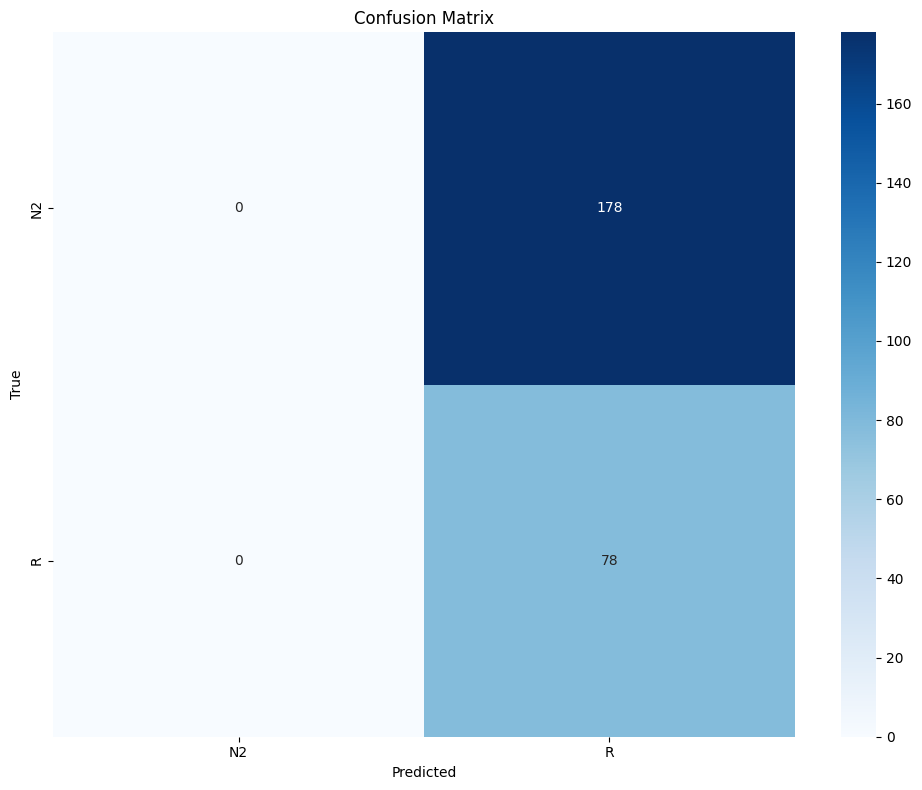

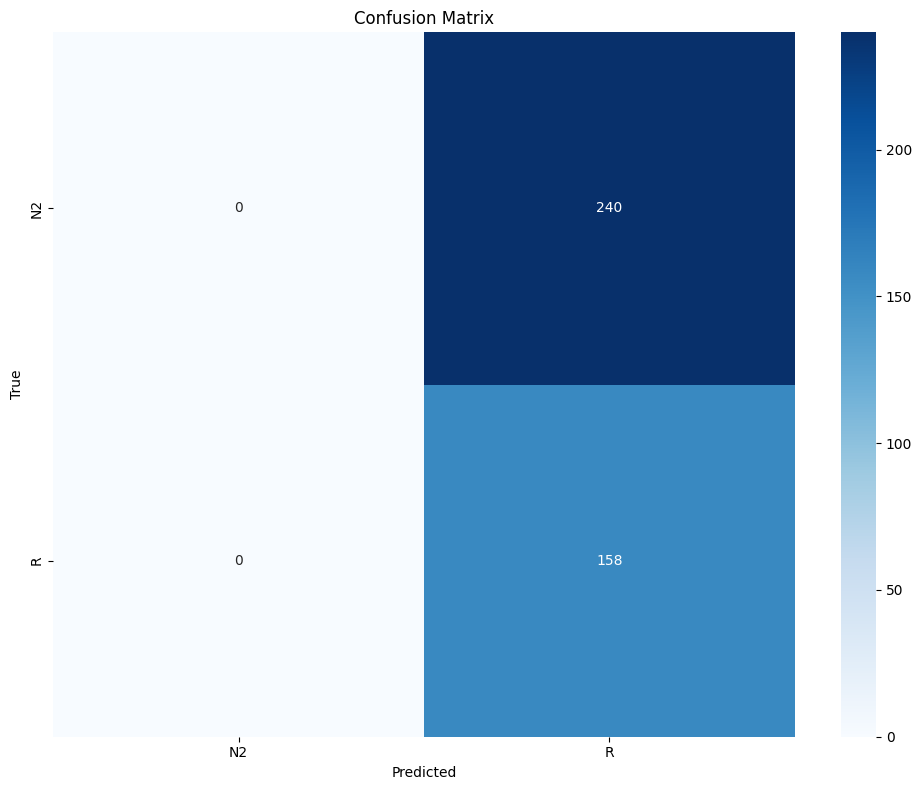

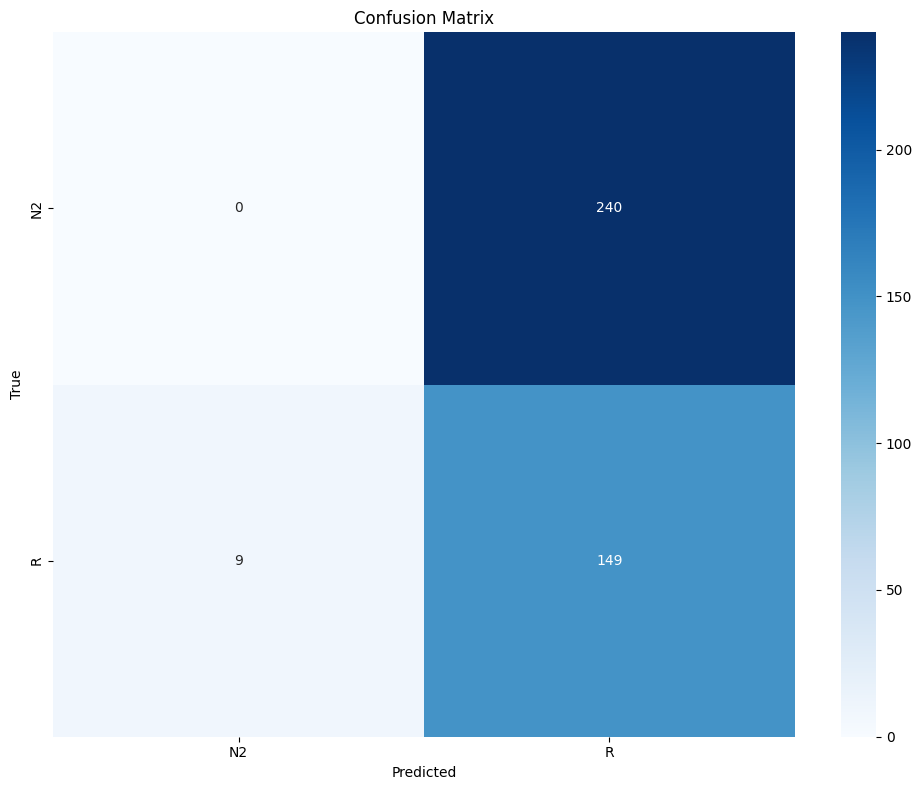

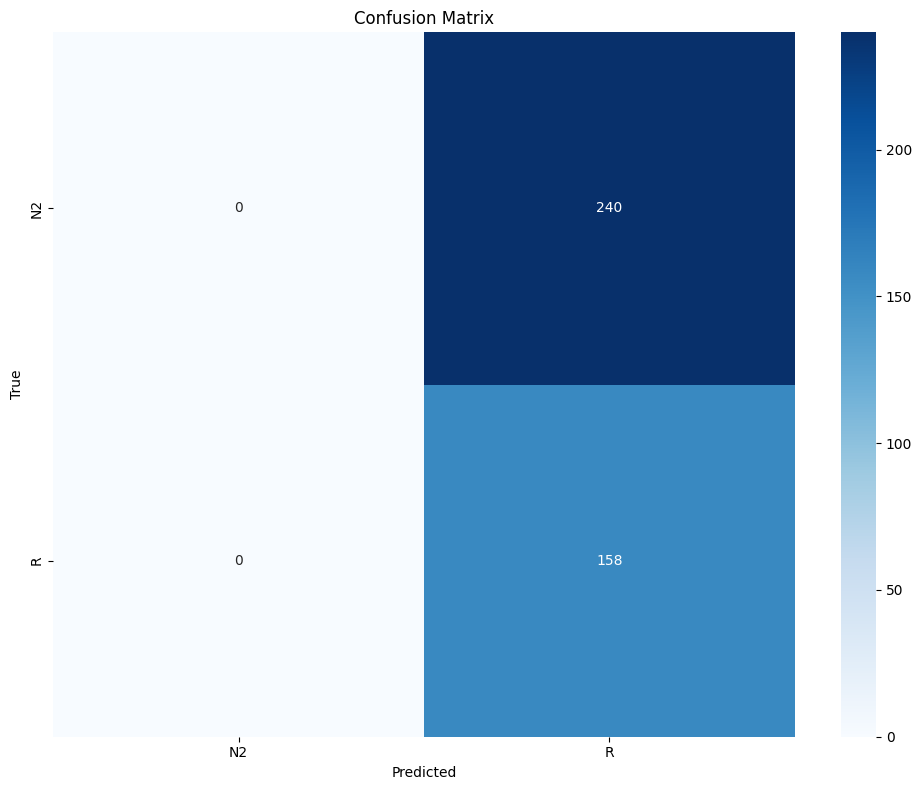

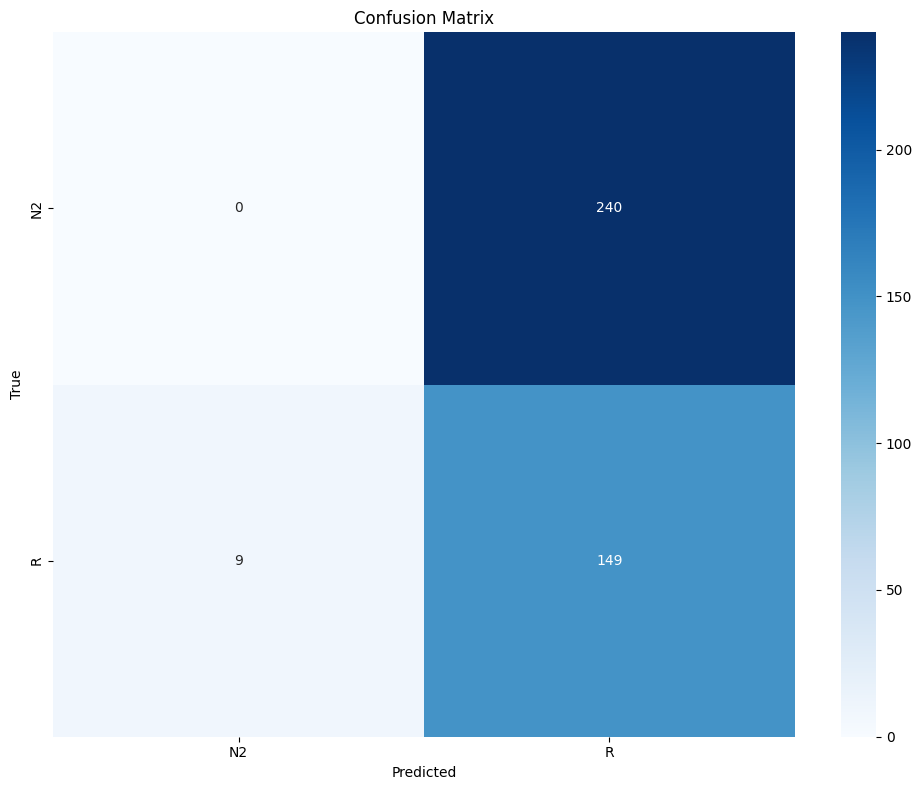

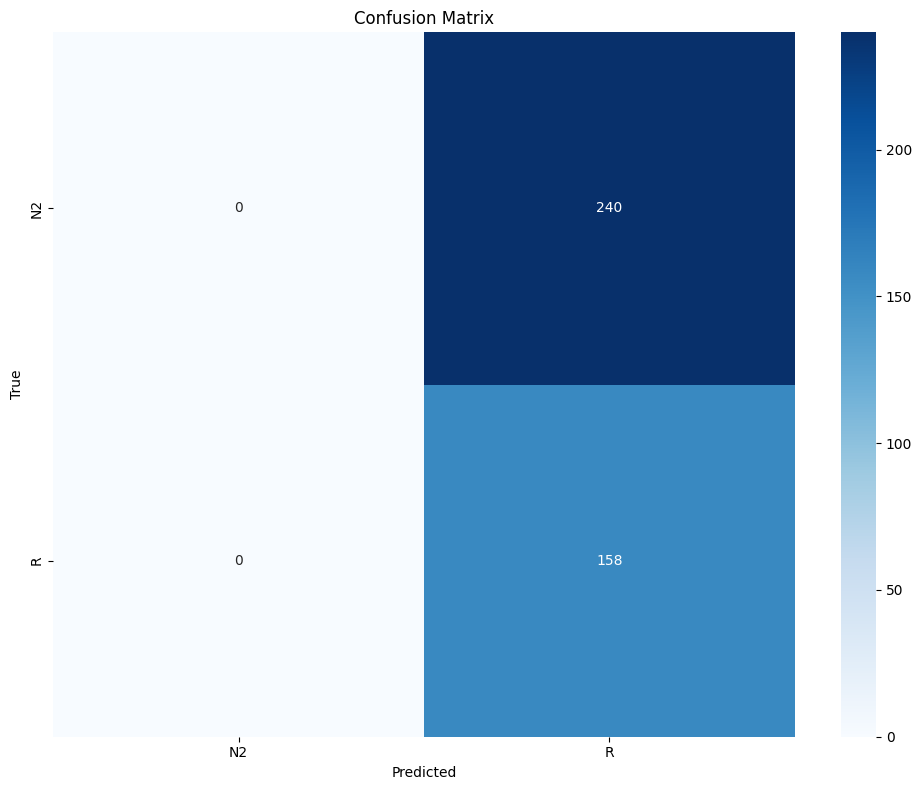

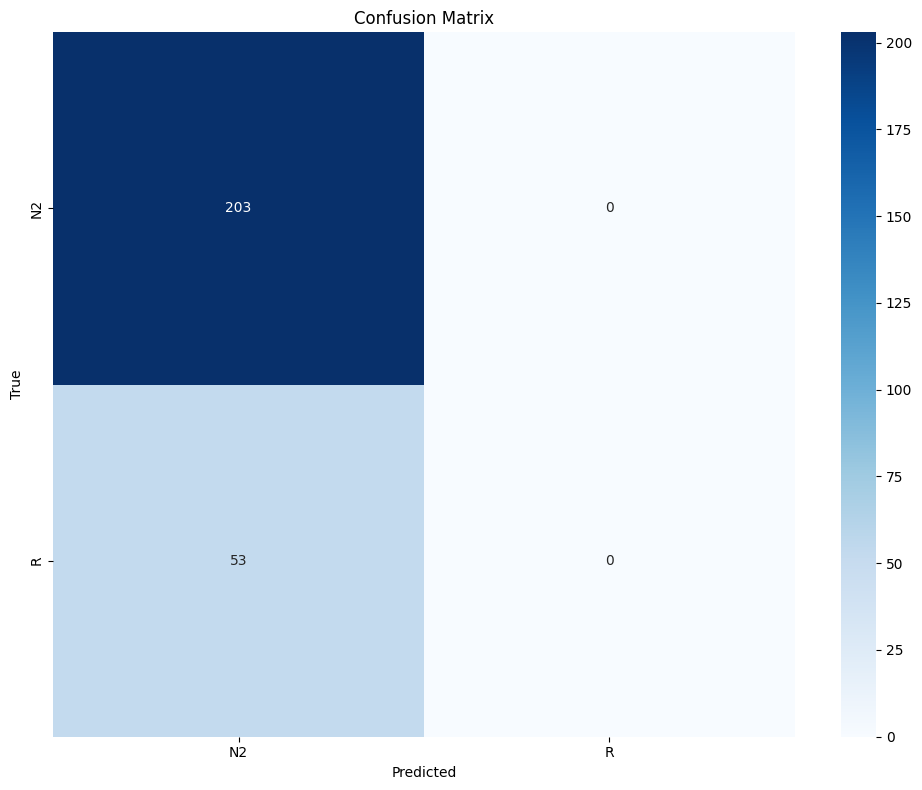

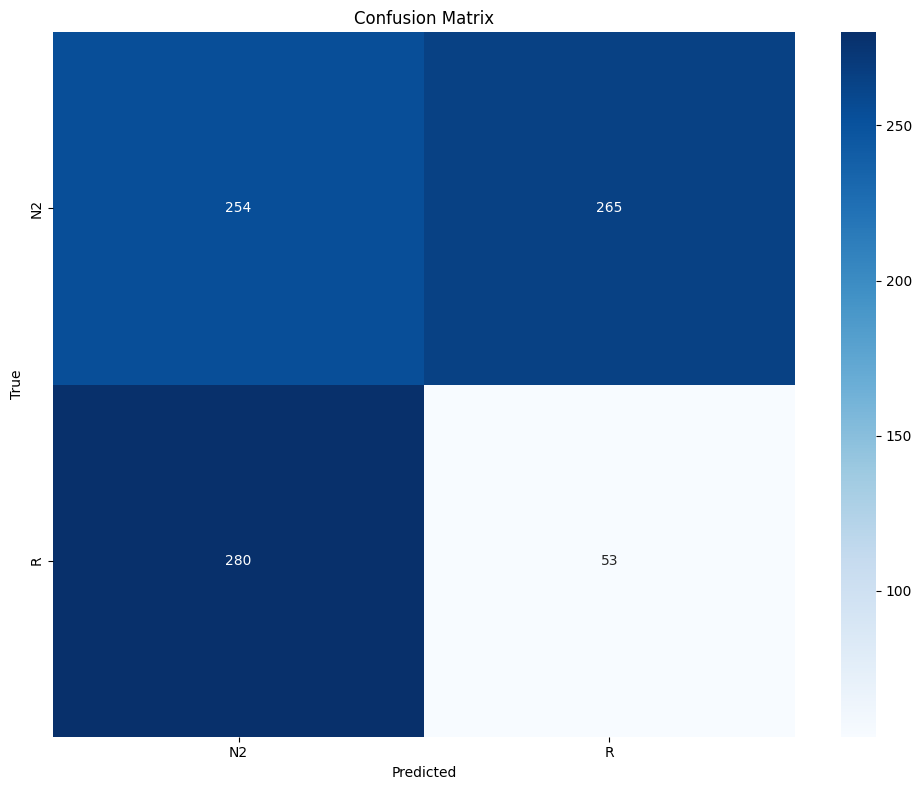

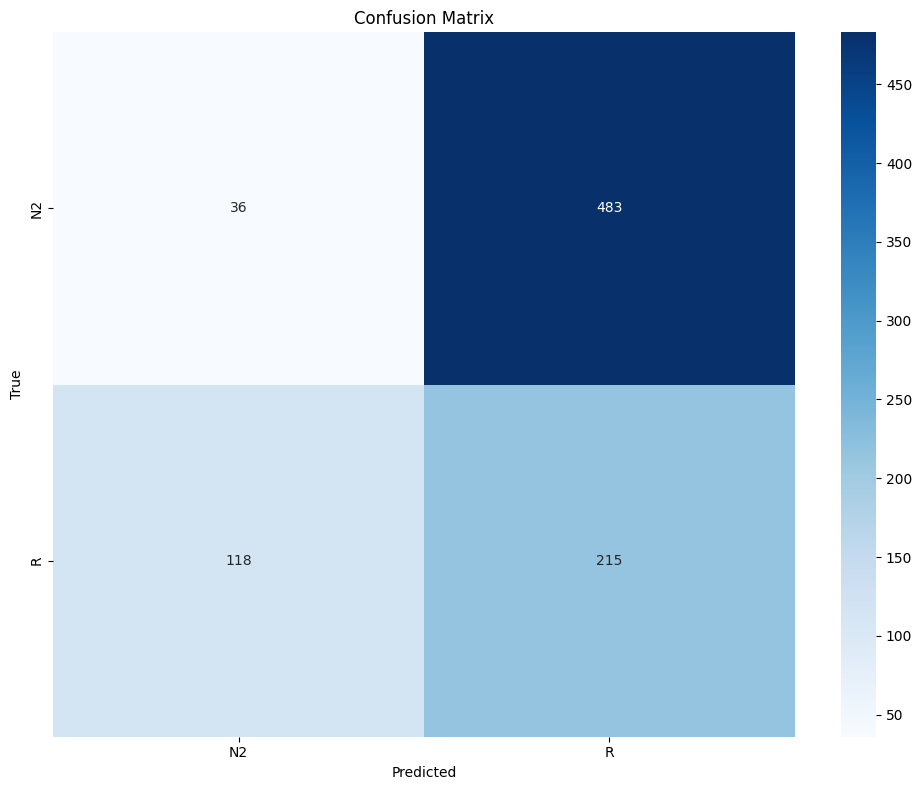

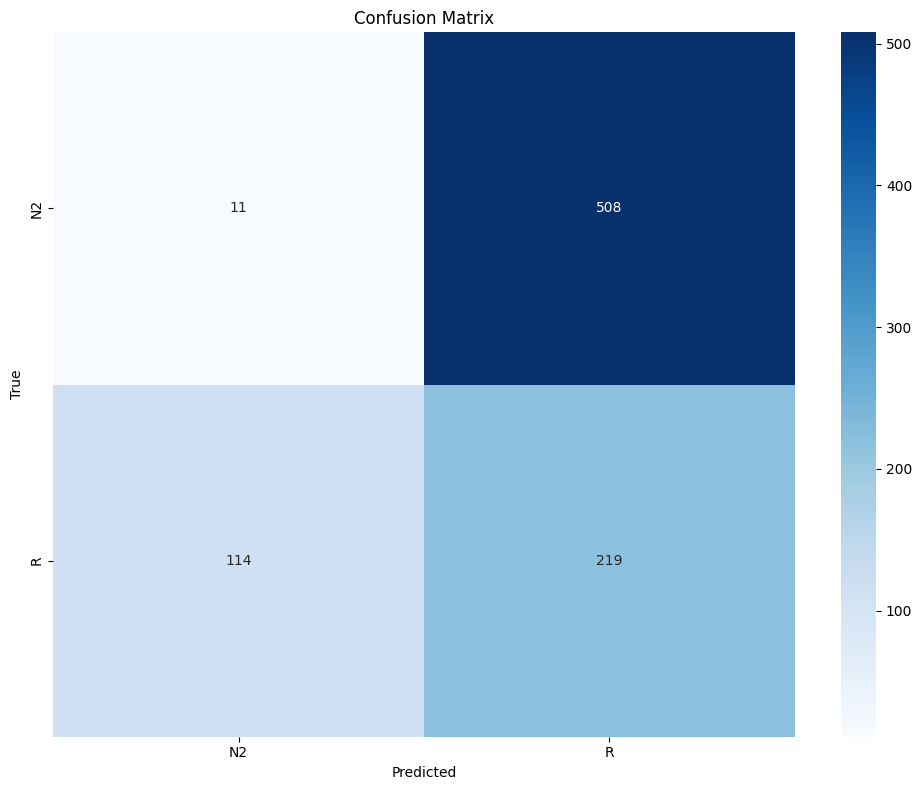

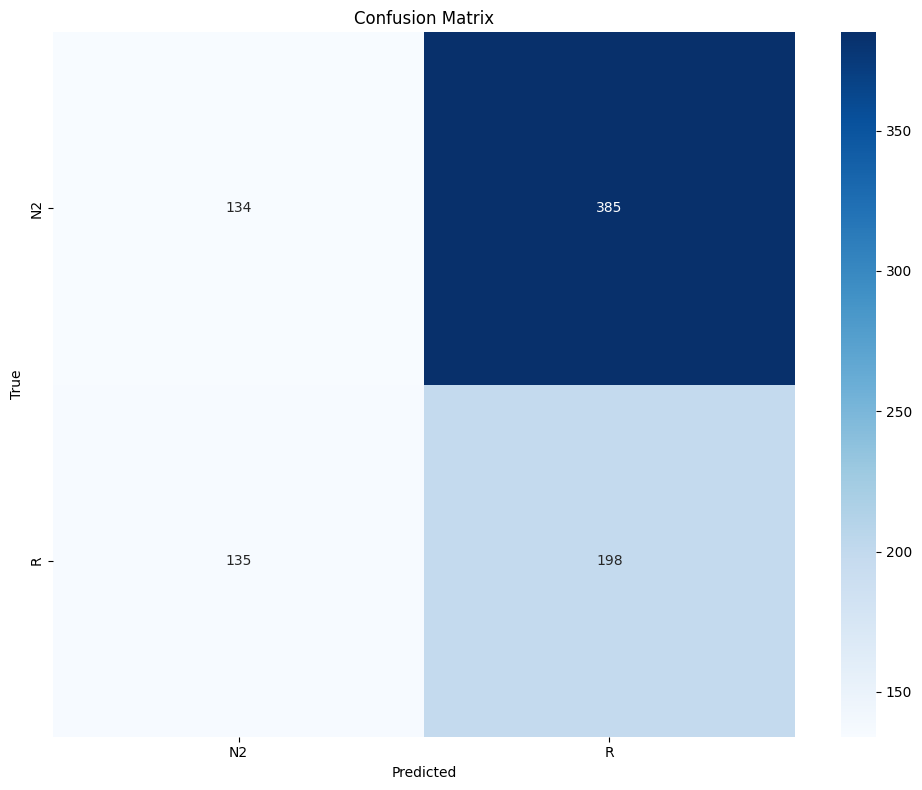

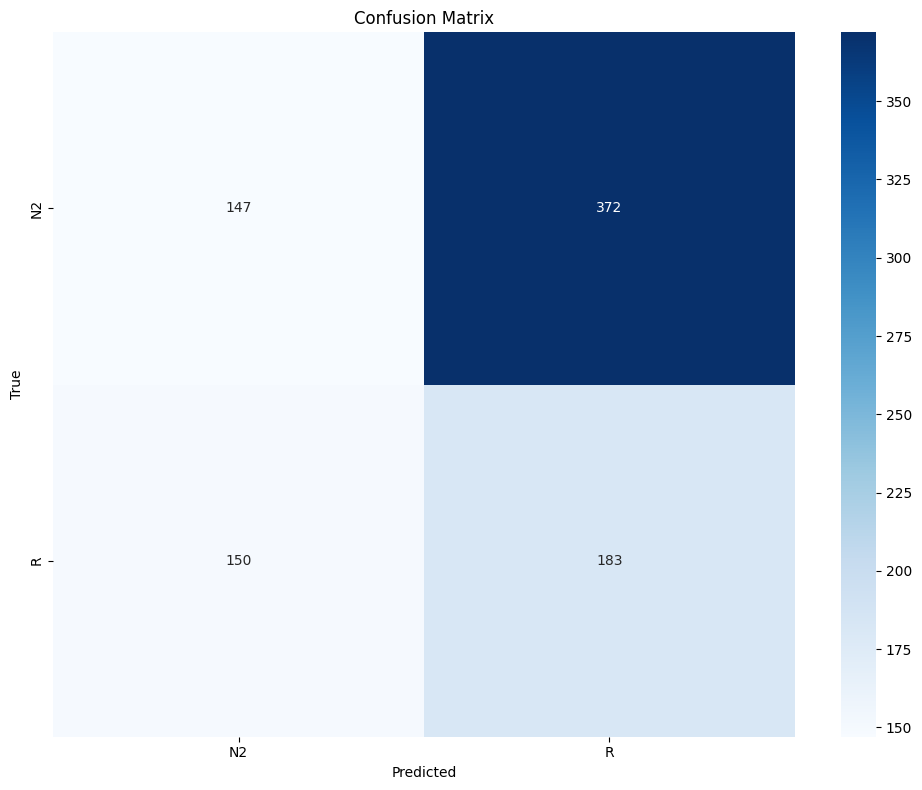

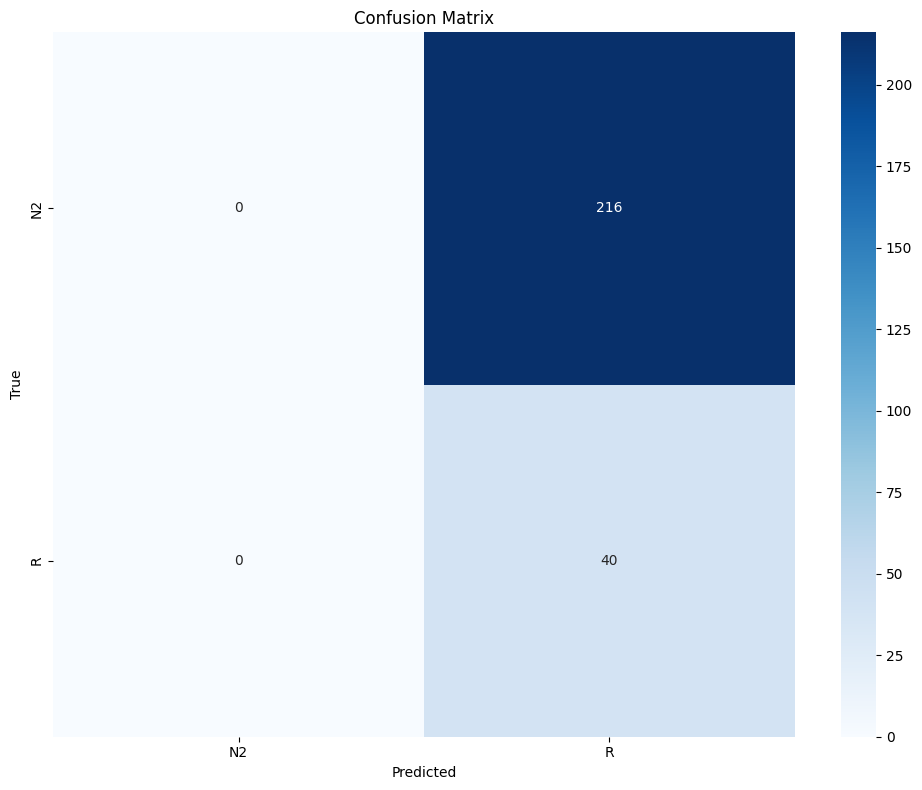

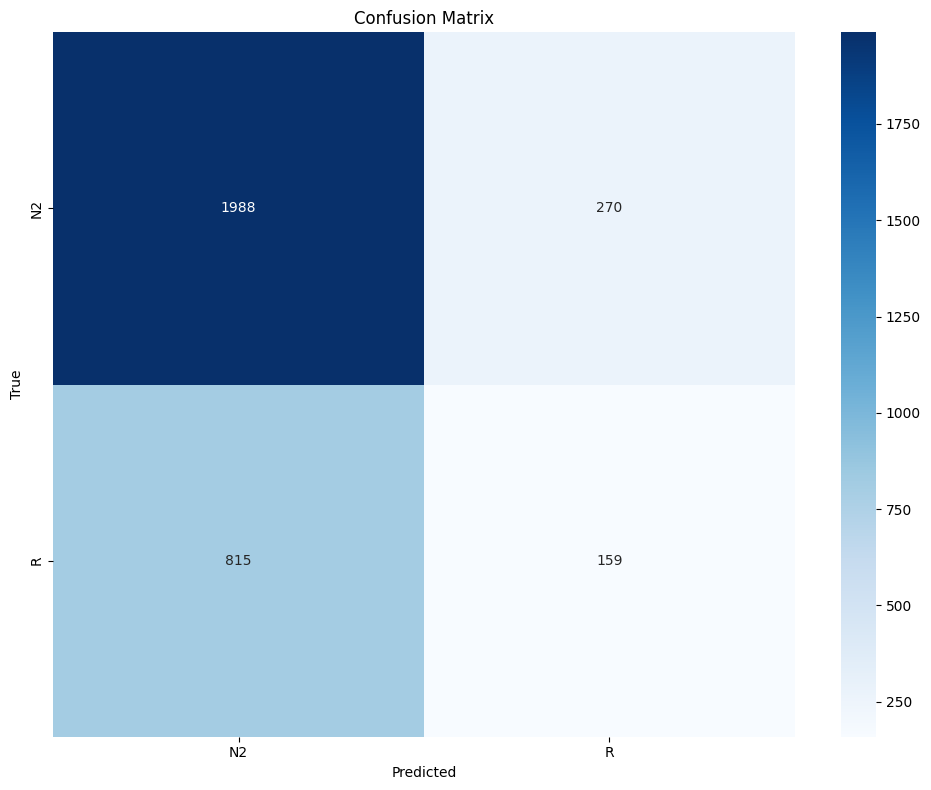

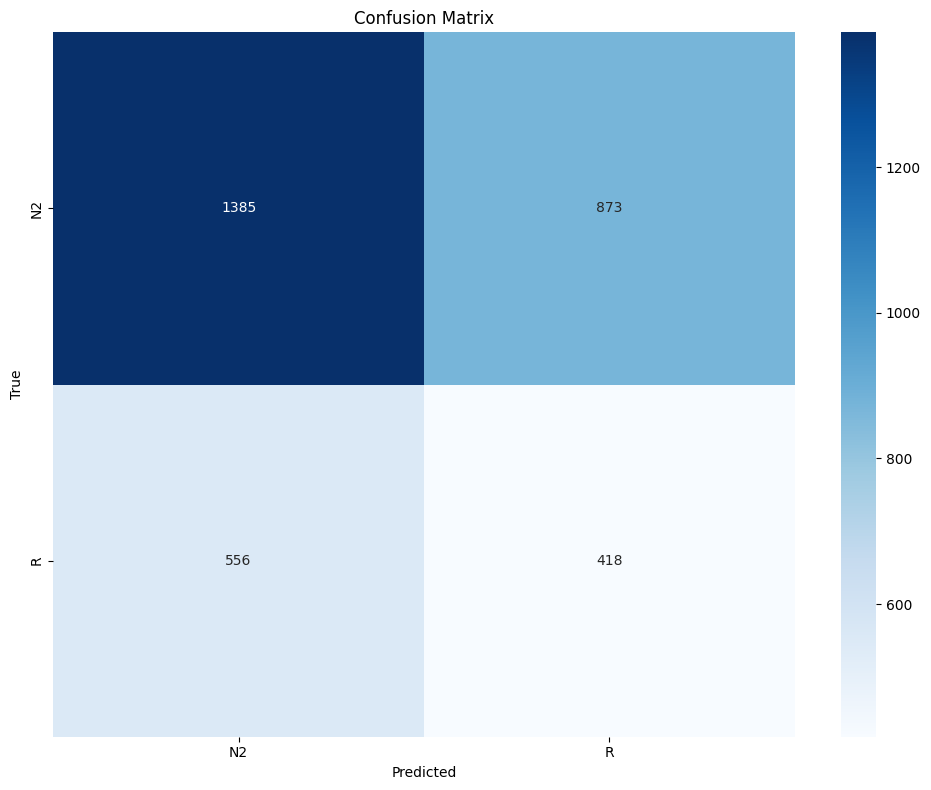

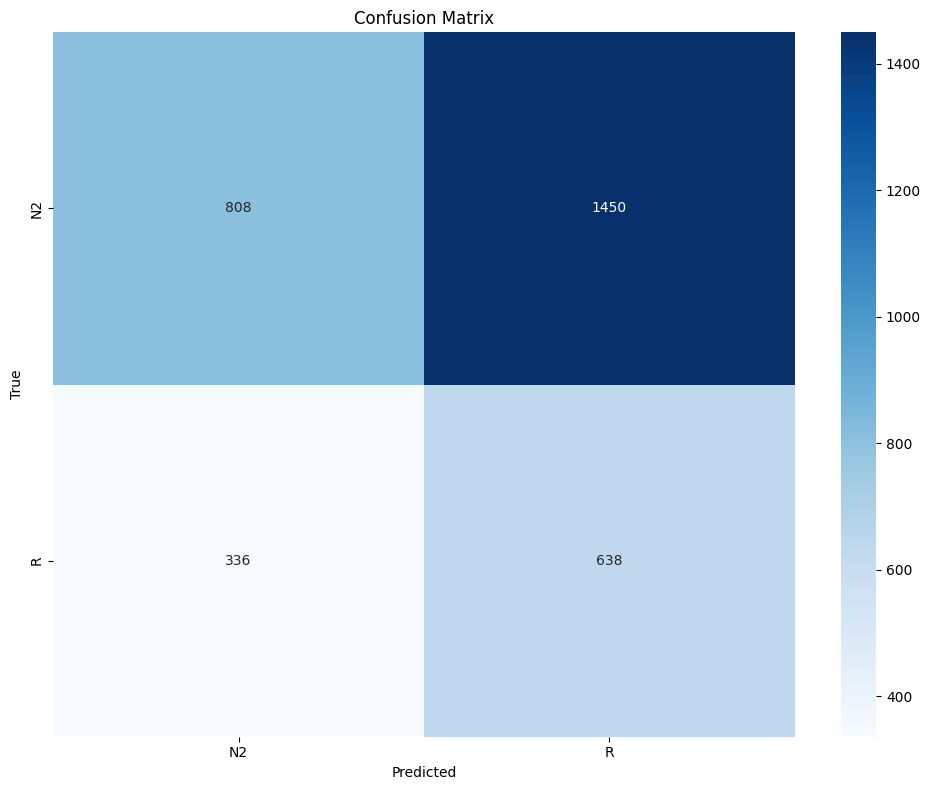

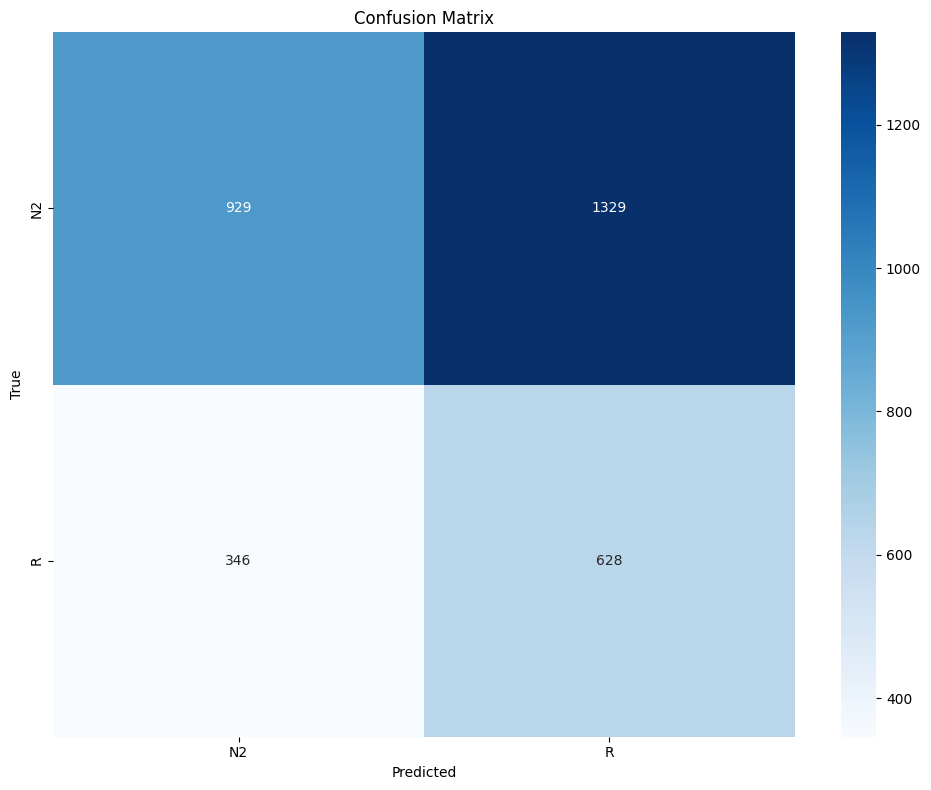

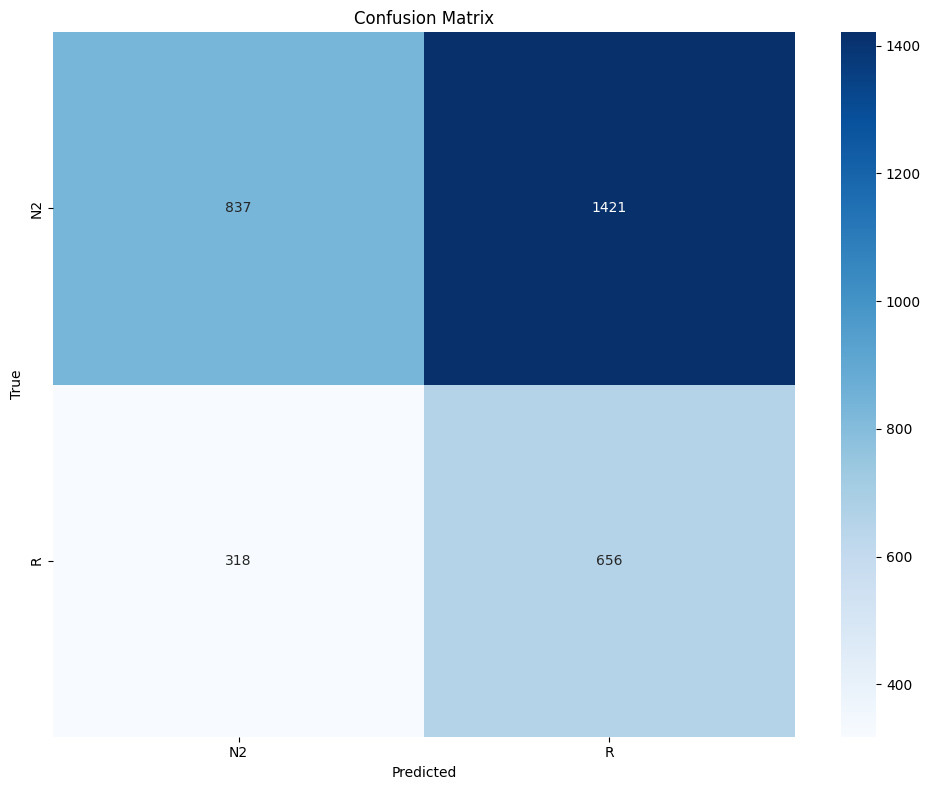

In [40]:
# ---------------------------
# 5. Model Architecture (Enhanced)
# ---------------------------

class SleepClassifier(nn.Module):
    def __init__(self, input_channels: int, num_classes: int):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(input_channels, 64, 3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(128, 256, 3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        return self.classifier(features)

class LightningWrapper(pl.LightningModule):
    def __init__(self, model: nn.Module, lr: float, class_labels: List[str]):
        super().__init__()
        self.model = model
        self.lr = lr
        self.class_labels = class_labels
        self.loss_fn = nn.CrossEntropyLoss()

        # Initialize metrics for both training and validation
        self.num_classes = len(class_labels)
        self.train_metrics = torchmetrics.MetricCollection({
            'acc': Accuracy(task='multiclass', num_classes=self.num_classes),
            'f1': F1Score(task='multiclass', num_classes=self.num_classes, average='macro')
        })

        self.val_metrics = torchmetrics.MetricCollection({
            'acc': Accuracy(task='multiclass', num_classes=self.num_classes),
            'f1': F1Score(task='multiclass', num_classes=self.num_classes, average='macro'),
            'precision': Precision(task='multiclass', num_classes=self.num_classes, average='macro'),
            'recall': Recall(task='multiclass', num_classes=self.num_classes, average='macro'),
            'auc': AUROC(task='multiclass', num_classes=self.num_classes)
        })

        self.conf_matrix = ConfusionMatrix(task='multiclass', num_classes=self.num_classes)
        self.val_outputs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)

        # Update training metrics
        self.train_metrics(y_hat.softmax(dim=1), y)
        self.log_dict({f'train_{k}': v for k, v in self.train_metrics.items()},
                     on_step=False, on_epoch=True)
        self.log('train_loss', loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)

        # Log validation loss explicitly
        self.log('val_loss', loss, prog_bar=True)

        # Update validation metrics
        self.val_metrics(y_hat.softmax(dim=1), y)
        self.conf_matrix(y_hat.argmax(dim=1), y)

        # Store for epoch-end
        self.val_outputs.append({
            'preds': y_hat.argmax(dim=1),
            'targets': y
        })

        return loss

    def on_validation_epoch_end(self):
        # Log validation metrics
        val_metrics = self.val_metrics.compute()
        self.log_dict({f'val_{k}': v for k, v in val_metrics.items()}, prog_bar=True)

        # Confusion matrix and classification report
        cm = self.conf_matrix.compute()
        fig = self.plot_confusion_matrix(cm)

        # Log to ClearML
        for logger in self.loggers:
            if isinstance(logger, ClearMLLogger):
                logger.logger.report_matplotlib_figure(
                    title="Confusion Matrix",
                    series=f"Epoch {self.current_epoch}",
                    figure=fig,
                    iteration=self.current_epoch
                )

        # Classification report
        all_preds = torch.cat([x['preds'] for x in self.val_outputs]).cpu().numpy()
        all_targets = torch.cat([x['targets'] for x in self.val_outputs]).cpu().numpy()

        report = classification_report(
            all_targets, all_preds,
            target_names=self.class_labels,
            output_dict=True,
            zero_division=0
        )
        report_df = pd.DataFrame(report).transpose().reset_index()

        for logger in self.loggers:
            if isinstance(logger, ClearMLLogger):
                logger.logger.report_table(
                    title='Classification Report',
                    series=f'Epoch {self.current_epoch}',
                    table_plot=report_df
                )

        # Reset metrics
        self.val_metrics.reset()
        self.conf_matrix.reset()
        self.val_outputs.clear()


        # # Reset metrics
        # self.val_outputs.clear()
        # self.val_acc.reset()
        # self.val_f1.reset()
        # self.val_precision.reset()
        # self.val_recall.reset()
        # self.val_auc.reset()
        # self.val_cm.reset()

    def plot_confusion_matrix(self, cm):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_labels,
                    yticklabels=self.class_labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        return plt.gcf()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=3, verbose=True
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'interval': 'epoch',
                'frequency': 1
            }
        }

# ---------------------------
# 6. Enhanced Training Pipeline
# ---------------------------
def run_training(config: dict):
    """Final corrected training workflow"""
    # Initialize custom logger
    logger = ClearMLLogger(task_name="Final-1DCNN")
    logger.log_hyperparams(config)

    try:
        # Load data
        combined_df, processed_data, class_labels = load_and_preprocess_data(config['data_dir'])

        # Initialize data module
        datamodule = SleepDataModule(processed_data, config)
        datamodule.setup()

        for test_subject in datamodule.datasets.keys():
            print(f"\n{'='*40}\nFold: {test_subject}")

            # Model setup
            model = LightningWrapper(
                SleepClassifier(19, len(class_labels)),
                lr=config['learning_rate'],
                class_labels=class_labels
            )

            # Configure trainer with proper logger
            trainer = Trainer(
                max_epochs=config['max_epochs'],
                logger=logger,
                log_every_n_steps=5,
                callbacks=[
                    EarlyStopping(monitor="val_acc", patience=5, mode="max"),
                    ModelCheckpoint(
                        dirpath=config['checkpoint_path'],
                        filename=f"best-{test_subject}",
                        monitor="val_acc",
                        mode="max"
                    )
                ],
                deterministic=True,
                enable_progress_bar=True,
                enable_model_summary=True
            )

            # Get data loaders
            train_loader, val_loader = datamodule.get_loso_splits(test_subject)

            # Train/validate
            trainer.fit(model, train_loader, val_loader)

    except Exception as e:
        logger.task.get_logger().report_text(f"Training failed: {str(e)}")
        raise
    finally:
        logger.finalize("success")

# ---------------------------
# 7. Main Execution
# ---------------------------
if __name__ == "__main__":
    # Clean checkpoint directory
    if os.path.exists(CONFIG['checkpoint_path']):
        shutil.rmtree(CONFIG['checkpoint_path'])
    os.makedirs(CONFIG['checkpoint_path'], exist_ok=True)

    run_training(CONFIG)

In [48]:
# ---------------------------
# 8. Results Analysis
# ---------------------------
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    roc_auc_score
)

def analyze_results(config: dict, class_labels: List[str]):
    """Calculate final metrics and generate analysis reports"""
    # Load data and prepare datasets
    _, processed_data, class_labels = load_and_preprocess_data(config['data_dir'])
    datamodule = SleepDataModule(processed_data, config)
    datamodule.setup()

    all_true = []
    all_preds = []
    all_probs = []
    volunteer_results = {}

    # Adjust probability handling based on class count
    n_classes = len(class_labels)

    # Load best models and gather predictions
    for vol_id in datamodule.datasets.keys():
        # Load model checkpoint
        ckpt_path = os.path.join(config['checkpoint_path'], f'best-{vol_id}.ckpt')
        model = LightningWrapper.load_from_checkpoint(
            ckpt_path,
            model=SleepClassifier(19, len(class_labels)),
            lr=config['learning_rate'],
            class_labels=class_labels
        )
        model.eval()

        # Get test data
        _, test_loader = datamodule.get_loso_splits(vol_id)

        # Run inference
        true_labels = []
        predictions = []
        probabilities = []
        with torch.no_grad():
            for x, y in test_loader:
                outputs = model(x)
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)

                true_labels.extend(y.numpy())
                predictions.extend(preds.numpy())
                probabilities.extend(probs.numpy())

        # Convert probabilities based on class count
        prob_array = np.array(probabilities)
        if n_classes == 2:
            # For binary classification, use positive class probabilities
            prob_array = prob_array[:, 1]  # Get probabilities for class 1

        # Calculate AUC
        try:
            auc_score = roc_auc_score(true_labels, prob_array,
                                     multi_class='ovr' if n_classes > 2 else 'raise')
        except ValueError:
            auc_score = np.nan

        volunteer_results[vol_id] = {
            'accuracy': accuracy_score(true_labels, predictions),
            'f1': f1_score(true_labels, predictions, average='macro'),
            'auc': auc_score
        }

    # Convert to numpy arrays
    all_true = np.array(all_true)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # 1. Overall Metrics
    print("\n=== Overall Classification Report ===")
    print(classification_report(all_true, all_preds, target_names=class_labels))

    print("\n=== Macro Averages ===")
    print(f"Accuracy: {accuracy_score(all_true, all_preds):.3f}")
    print(f"F1-Score: {f1_score(all_true, all_preds, average='macro'):.3f}")
    print(f"AUC-ROC: {roc_auc_score(all_true, all_probs, multi_class='ovo', average='macro'):.3f}")

    # 2. Per-Volunteer Performance
    print("\n=== Per-Volunteer Performance ===")
    vol_df = pd.DataFrame.from_dict(volunteer_results, orient='index')
    print(vol_df.describe())

    # 3. Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(all_true, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('final_confusion_matrix.png')
    plt.close()

    # 4. Class-wise Metrics
    class_report = classification_report(all_true, all_preds,
                                        target_names=class_labels, output_dict=True)
    class_df = pd.DataFrame(class_report).transpose()
    class_df['auc'] = roc_auc_score(all_true, all_probs, multi_class='ovo', average=None)

    print("\n=== Class-wise Performance ===")
    print(class_df)

    # 5. Save Results
    results = {
        'overall': {
            'accuracy': accuracy_score(all_true, all_preds),
            'f1_macro': f1_score(all_true, all_preds, average='macro'),
            'auc_macro': roc_auc_score(all_true, all_probs, multi_class='ovo', average='macro')
        },
        'per_volunteer': volunteer_results,
        'class_wise': class_report
    }

    pd.DataFrame(results['per_volunteer']).to_csv('per_volunteer_results.csv')
    class_df.to_csv('class_wise_metrics.csv')

    return results

# Execute analysis
final_results = analyze_results(CONFIG, common_labels)

Loading raw data...
Common labels: ['N2', 'R']

=== Overall Classification Report ===


ValueError: Number of classes, 0, does not match size of target_names, 2. Try specifying the labels parameter

In [41]:
# class LightningWrapper(pl.LightningModule):
#     def __init__(self, model: nn.Module, lr: float, class_labels: List[str]):
#         super().__init__()
#         self.model = model
#         self.lr = lr
#         self.class_labels = class_labels
#         self.loss_fn = nn.CrossEntropyLoss()

#         # Initialize metric containers instead of metric objects
#         self.num_classes = len(class_labels)
#         self.metrics = torchmetrics.MetricCollection({
#             'acc': Accuracy(task='multiclass', num_classes=self.num_classes),
#             'f1': F1Score(task='multiclass', num_classes=self.num_classes, average='macro'),
#             'precision': Precision(task='multiclass', num_classes=self.num_classes, average='macro'),
#             'recall': Recall(task='multiclass', num_classes=self.num_classes, average='macro'),
#             'auc': AUROC(task='multiclass', num_classes=self.num_classes)
#         })
#         self.conf_matrix = ConfusionMatrix(task='multiclass', num_classes=self.num_classes)

#         # Storage for epoch-level metrics
#         self.val_outputs = []

#     def forward(self, x):
#         return self.model(x)

#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         y_hat = self(x)
#         loss = self.loss_fn(y_hat, y)
#         self.train_acc(y_hat.argmax(dim=1), y)
#         self.log('train_loss', loss, prog_bar=True)
#         self.log('train_acc', self.train_acc, prog_bar=True)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         y_hat = self(x)
#         loss = self.loss_fn(y_hat, y)

#         # Filter out invalid samples
#         valid_mask = y < self.num_classes  # Ensure labels are within class range
#         if valid_mask.any():
#             y_hat_valid = y_hat[valid_mask]
#             y_valid = y[valid_mask]

#             # Update metrics
#             self.metrics.update(y_hat_valid.softmax(dim=1), y_valid)
#             self.conf_matrix.update(y_hat_valid.argmax(dim=1), y_valid)

#             # Store for epoch-end
#             self.val_outputs.append({
#                 'preds': y_hat_valid.argmax(dim=1),
#                 'targets': y_valid
#             })

#         return loss

#     def on_validation_epoch_end(self):
#         # Compute metrics only if we have validation data
#         if len(self.val_outputs) > 0:
#             # Compute standard metrics
#             metrics = self.metrics.compute()
#             self.log_dict({f'val_{k}': v for k, v in metrics.items()})

#             # Confusion matrix
#             cm = self.conf_matrix.compute()
#             fig = self.plot_confusion_matrix(cm)
#             if any(isinstance(logger, ClearMLLogger) for logger in self.loggers):
#                 for logger in self.loggers:
#                     if isinstance(logger, ClearMLLogger):
#                         logger.logger.report_matplotlib_figure(
#                             title="Confusion Matrix",
#                             series=f"Epoch {self.current_epoch}",
#                             figure=fig,
#                             iteration=self.current_epoch
#                         )

#             # Classification report
#             all_preds = torch.cat([x['preds'] for x in self.val_outputs]).cpu().numpy()
#             all_targets = torch.cat([x['targets'] for x in self.val_outputs]).cpu().numpy()

#             if len(all_preds) > 0:
#                 report = classification_report(
#                     all_targets, all_preds,
#                     target_names=self.class_labels,
#                     output_dict=True,
#                     zero_division=0
#                 )
#                 report_df = pd.DataFrame(report).transpose().reset_index()
#                 report_df = report_df.fillna(0)

#                 if any(isinstance(logger, ClearMLLogger) for logger in self.loggers):
#                     for logger in self.loggers:
#                         if isinstance(logger, ClearMLLogger):
#                             logger.logger.report_table(
#                                 title='Classification Report',
#                                 series=f'Epoch {self.current_epoch}',
#                                 table_plot=report_df
#                             )

#             # Reset metrics
#             self.metrics.reset()
#             self.conf_matrix.reset()
#             self.val_outputs.clear()

In [42]:
# # ---------------------------
# # 3. Data Loading & Preprocessing
# # ---------------------------
# def load_and_preprocess_data(directory: str) -> Tuple[Dict[str, tuple], List[str]]:
#     """Robust data loader with full header handling"""
#     volunteer_data = defaultdict(list)
#     label_sets = []
#     feature_means = None

#     # First pass: Calculate global feature means
#     print("Calculating global feature means...")
#     all_features = []
#     valid_files = 0

#     for filename in os.listdir(directory):
#         if not (filename.startswith("Vol_") and filename.endswith(".csv.gz")):
#             continue

#         file_path = os.path.join(directory, filename)
#         try:
#             # Skip header and handle types
#             df = pd.read_csv(
#                 file_path,
#                 compression='gzip',
#                 skiprows=1,  # Skip header row
#                 header=None,
#                 dtype={i: np.float32 for i in range(19)},  # Enforce numeric types
#                 on_bad_lines='warn'
#             )
#             df.columns = [f"feature_{i}" for i in range(19)] + ["label"]

#             # Validate label column
#             df['label'] = df['label'].str.strip().replace('', np.nan)
#             df = df.dropna(subset=['label'])

#             if not df.empty:
#                 all_features.append(df.iloc[:, :-1].values)
#                 valid_files += 1

#         except Exception as e:
#             print(f"Skipping {filename}: {str(e)}")
#             continue

#     if not all_features:
#         raise ValueError("No valid data found in any files")

#     # Calculate global statistics
#     feature_means = np.nanmean(np.concatenate(all_features), axis=0)
#     print(f"Processed {valid_files} files with global feature means:\n{feature_means}")

#     # Second pass: Process files with imputation
#     for filename in os.listdir(directory):
#         if not (filename.startswith("Vol_") and filename.endswith(".csv.gz")):
#             continue

#         file_path = os.path.join(directory, filename)
#         print(f"\nProcessing: {filename}")

#         try:
#             # Read with consistent header handling
#             df = pd.read_csv(
#                 file_path,
#                 compression='gzip',
#                 skiprows=1,  # Skip header row
#                 header=None,
#                 dtype={i: np.float32 for i in range(19)},
#                 on_bad_lines='warn'
#             )
#             df.columns = [f"feature_{i}" for i in range(19)] + ["label"]

#             # Clean labels
#             df['label'] = df['label'].str.strip().replace('', np.nan)
#             df = df.dropna(subset=['label'])

#             if df.empty:
#                 print("  No valid rows with labels - skipping")
#                 continue

#             # Impute missing values
#             for i in range(19):
#                 df[f'feature_{i}'] = df[f'feature_{i}'].fillna(feature_means[i])

#             # Store data
#             features = df.iloc[:, :-1].values.astype(np.float32)
#             labels = df['label'].values

#             volunteer_id = filename.split("_")[1].split(".")[0]
#             volunteer_data[volunteer_id].append((features, labels))
#             label_sets.append(set(labels))

#             print(f"  Successfully processed {len(features)} samples")
#             print(f"  Unique labels: {sorted(set(labels))}")

#         except Exception as e:
#             print(f"  Failed to process: {str(e)}")
#             continue

#     # Handle labels with threshold
#     label_counts = {}
#     for labels in label_sets:
#         for lbl in labels:
#             label_counts[lbl] = label_counts.get(lbl, 0) + 1

#     # Require labels present in at least 60% of volunteers
#     min_volunteers = int(1.0 * len(volunteer_data))
#     common_labels = [lbl for lbl, count in label_counts.items() if count >= min_volunteers]

#     if not common_labels:
#         print("\nLabel distribution across volunteers:")
#         for i, labels in enumerate(label_sets):
#             print(f"Volunteer {i+1}: {sorted(labels)}")
#         raise ValueError(f"No labels common across at least {min_volunteers} volunteers")

#     print(f"\nFinal labels: {common_labels}")

#     # After determining common_labels:
#     label_to_id = {label: idx for idx, label in enumerate(common_labels)}
#     print(f"\nLabel encoding: {label_to_id}")

#     # Process and normalize data
#     merged_data = {}
#     for vol_id, data_list in volunteer_data.items():
#         all_features = np.concatenate([x[0] for x in data_list])
#         all_labels = np.concatenate([x[1] for x in data_list])

#         # Filter to common labels and encode to integers
#         valid_mask = np.isin(all_labels, common_labels)
#         features = all_features[valid_mask]
#         str_labels = all_labels[valid_mask]
#         labels = np.vectorize(label_to_id.get)(str_labels)  # Convert to integers

#         if len(features) == 0:
#             print(f"Skipping {vol_id} - no common label data")
#             continue

#         # Normalize features
#         features = (features - feature_means) / (np.std(features, axis=0) + 1e-8)

#         merged_data[f"Vol_{vol_id}"] = (features, labels)
#         print(f"\nVolunteer {vol_id} summary:")
#         print(f"- Total samples: {len(features)}")
#         print("- Label distribution:")
#         for lbl in common_labels:
#             print(f"  {lbl}: {np.sum(labels == lbl)} samples")

#     return merged_data, common_labels

In [43]:
# # ---------------------------
# # 4. Dataset & DataModule (Corrected)
# # ---------------------------
# class SleepDataset(Dataset):
#     def __init__(self, features: np.ndarray, labels: np.ndarray, window_size: int):
#         self.windows, self.labels = self._create_windows(features, labels, window_size)
#         # Convert to tensors during initialization
#         self.windows = torch.tensor(self.windows, dtype=torch.float32)
#         self.labels = torch.tensor(self.labels, dtype=torch.long)

#     def _create_windows(self, features, labels, window_size):
#         windows = []
#         window_labels = []
#         for start in range(0, len(features) - window_size + 1, window_size//2):
#             end = start + window_size
#             window = features[start:end].T  # (features, time)
#             label = labels[end-1]
#             windows.append(window)
#             window_labels.append(label)
#         return np.array(windows), np.array(window_labels)

#     def __len__(self):
#         return len(self.windows)

#     def __getitem__(self, idx):
#         return self.windows[idx], self.labels[idx]

# class SleepDataModule(pl.LightningDataModule):
#     def __init__(self, merged_data: Dict[str, tuple], config: dict):
#         super().__init__()  # Initialize parent class
#         self.data = merged_data
#         self.config = config
#         self.batch_size = config['batch_size']
#         self.window_size = config['window_size']
#         self.datasets = {}

#     def setup(self, stage: Optional[str] = None):
#         """Create windowed datasets for all volunteers"""
#         for vol_id, (features, labels) in self.data.items():
#             try:
#                 # Convert to sliding windows
#                 windows, window_labels = self._create_windows(features, labels)
#                 self.datasets[vol_id] = TensorDataset(
#                     torch.tensor(windows, dtype=torch.float32),
#                     torch.tensor(window_labels, dtype=torch.long)
#                 )
#             except Exception as e:
#                 print(f"Error processing {vol_id}: {str(e)}")

#     def _create_windows(self, features: np.ndarray, labels: np.ndarray):
#         """Generate time-series windows with overlap"""
#         windows = []
#         window_labels = []
#         for start in range(0, len(features) - self.window_size + 1, self.window_size // 2):
#             end = start + self.window_size
#             window = features[start:end].T  # (features, time)
#             label = labels[end-1]
#             if not np.isnan(window).any():
#                 windows.append(window)
#                 window_labels.append(label)
#         return np.array(windows), np.array(window_labels)

#     def get_loso_splits(self, test_subject: str):
#         """Generate LOSO splits for a given test subject"""
#         train_data = []
#         train_labels = []

#         # Aggregate training data
#         for vol_id, dataset in self.datasets.items():
#             if vol_id != test_subject:
#                 train_data.append(dataset.tensors[0])
#                 train_labels.append(dataset.tensors[1])

#         return (
#             DataLoader(TensorDataset(torch.cat(train_data), torch.cat(train_labels)),
#                      batch_size=self.batch_size, shuffle=True),
#             DataLoader(self.datasets[test_subject], batch_size=self.batch_size)
#         )

In [44]:
# # ---------------------------
# # 5. Model Architecture
# # ---------------------------
# class SleepClassifier(nn.Module):
#     def __init__(self, input_channels: int, num_classes: int):
#         super().__init__()
#         self.layers = nn.Sequential(
#             nn.Conv1d(input_channels, 64, 3, padding=1),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),
#             nn.MaxPool1d(2),
#             nn.Conv1d(64, 128, 3, padding=1),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.MaxPool1d(2),
#             nn.Conv1d(128, 256, 3, padding=1),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.AdaptiveAvgPool1d(1),
#             nn.Flatten(),
#             nn.Linear(256, num_classes)
#         )

#     def forward(self, x):
#         return self.layers(x)

# class LightningWrapper(pl.LightningModule):
#     def __init__(self, model: nn.Module, lr: float):
#         super().__init__()
#         self.model = model
#         self.lr = lr
#         self.loss_fn = nn.CrossEntropyLoss()

#     def forward(self, x):
#         return self.model(x)

#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         y_hat = self(x)
#         loss = self.loss_fn(y_hat, y)
#         self.log("train_loss", loss, prog_bar=True)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         y_hat = self(x)
#         loss = self.loss_fn(y_hat, y)
#         acc = (y_hat.argmax(dim=1) == y).float().mean()
#         self.log("val_loss", loss, prog_bar=True)
#         self.log("val_acc", acc, prog_bar=True)
#         return loss

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=self.lr)

In [45]:
# # ---------------------------
# # 6. Training Pipeline
# # ---------------------------
# def run_training(config: dict):
#     """Complete training workflow"""
#     # Initialize ClearML
#     task = Task.init(project_name="SleepStaging", task_name="1DCNN-Baseline")
#     task.connect(config)

#     try:
#         # Load and validate data
#         merged_data, class_labels = load_and_preprocess_data(config['data_dir'])
#         print(f"Loaded data from {len(merged_data)} volunteers")
#         print(f"Class distribution: {class_labels}")

#         # Initialize components
#         datamodule = SleepDataModule(merged_data, config)
#         datamodule.setup()

#         # Training loop
#         for test_subject in datamodule.datasets.keys():
#             print(f"\n{'='*40}\nTraining on {len(datamodule.datasets)-1} subjects | Validating on {test_subject}")

#             # Model setup
#             model = LightningWrapper(
#                 SleepClassifier(input_channels=19, num_classes=len(class_labels)),
#                 lr=config['learning_rate']
#             )

#             # Configure trainer
#             trainer = Trainer(
#                 max_epochs=config['max_epochs'],
#                 callbacks=[
#                     EarlyStopping(monitor="val_acc", patience=5, mode="max"),
#                     ModelCheckpoint(
#                         dirpath=config['checkpoint_path'],
#                         filename=f"best-{test_subject}",
#                         monitor="val_acc",
#                         mode="max"
#                     )
#                 ],
#                 deterministic=True
#             )

#             # Get data loaders
#             train_loader, val_loader = datamodule.get_loso_splits(test_subject)

#             # Train/validate
#             trainer.fit(model, train_loader, val_loader)

#     except Exception as e:
#         task.get_logger().report_text(f"Training failed: {str(e)}")
#         raise
#     finally:
#         task.close()

# # ---------------------------
# # 7. Main Execution
# # ---------------------------
# if __name__ == "__main__":
#     os.makedirs(CONFIG['checkpoint_path'], exist_ok=True)
#     run_training(CONFIG)